In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Data loading and checking basic informations

df = pd.read_csv("Model_Ready_Traffic_Data.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14568 entries, 0 to 14567
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                14568 non-null  object 
 1   Hour                14568 non-null  int64  
 2   Junction            14568 non-null  int64  
 3   Vehicles            14568 non-null  int64  
 4   temp_norm           14568 non-null  float64
 5   humidity_norm       14568 non-null  float64
 6   precip_norm         14568 non-null  float64
 7   windspeed_norm      14568 non-null  float64
 8   DateTime            14568 non-null  object 
 9   Vehicles_lag_1      14568 non-null  float64
 10  Vehicles_lag_2      14568 non-null  float64
 11  Vehicles_lag_24     14568 non-null  float64
 12  DateTime_raw        14568 non-null  object 
 13  Time                14568 non-null  object 
 14  Vehicles_raw        14568 non-null  int64  
 15  ID                  14568 non-null  int64  
 16  temp

,Date,Hour,Junction,Vehicles,temp_norm,humidity_norm,precip_norm,windspeed_norm,DateTime,Vehicles_lag_1,...,Event_Name,Event_Type,temp_norm_raw,humidity_norm_raw,precip_norm_raw,windspeed_norm_raw,Day_of_Week,Month,Is_Weekend,Event_Flag
0,2015-11-02,0,1,14,0.481928,0.814757,0.471408,0.020339,2015-11-02 00:00:00,15.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
1,2015-11-02,1,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 01:00:00,14.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
2,2015-11-02,2,1,14,0.481928,0.814757,0.471408,0.020339,2015-11-02 02:00:00,12.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
3,2015-11-02,3,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 03:00:00,14.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1
4,2015-11-02,4,1,12,0.481928,0.814757,0.471408,0.020339,2015-11-02 04:00:00,12.0,...,NONE,NONE,0.481928,0.814757,0.471408,0.020339,Monday,11,0,1


In [4]:
print(df.columns)

Index(['Date', 'Hour', 'Junction', 'Vehicles', 'temp_norm', 'humidity_norm',
       'precip_norm', 'windspeed_norm', 'DateTime', 'Vehicles_lag_1',
       'Vehicles_lag_2', 'Vehicles_lag_24', 'DateTime_raw', 'Time',
       'Vehicles_raw', 'ID', 'temp', 'humidity', 'precip', 'windspeed',
       'weather conditions', 'Event_Name', 'Event_Type', 'temp_norm_raw',
       'humidity_norm_raw', 'precip_norm_raw', 'windspeed_norm_raw',
       'Day_of_Week', 'Month', 'Is_Weekend', 'Event_Flag'],
      dtype='object')


In [5]:
df['Junction'].nunique()
df['Junction'].value_counts()

Junction
1    14568
Name: count, dtype: int64

## Model Development and Training

#### Data Preparation

In [6]:
# Columns to remove to avoid redundancy, noise, and data leakage

drop_cols = [
    'Vehicles_raw',
    'Date', 'DateTime', 'DateTime_raw', 'Time', 'ID',
    'temp', 'humidity', 'precip', 'windspeed',
    'temp_norm_raw', 'humidity_norm_raw',
    'precip_norm_raw', 'windspeed_norm_raw',
    'Event_Name', 'Event_Type'
]

# # Drop unwanted columns; ignore errors if a column is missing
df = df.drop(columns=drop_cols, errors='ignore')

In [7]:
print(df.columns)

Index(['Hour', 'Junction', 'Vehicles', 'temp_norm', 'humidity_norm',
       'precip_norm', 'windspeed_norm', 'Vehicles_lag_1', 'Vehicles_lag_2',
       'Vehicles_lag_24', 'weather conditions', 'Day_of_Week', 'Month',
       'Is_Weekend', 'Event_Flag'],
      dtype='object')


#### Feature Encoding

In [8]:
# Convert categorical variables into numeric dummy variables

df = pd.get_dummies(
    df,
    columns=['Junction', 'weather conditions', 'Day_of_Week'],
    drop_first=True
)

#### Feature/Target Split

In [9]:
# Separate features (independent variables) and target variable

# Input features used for prediction
X = df.drop(columns=['Vehicles'])

# Target variable (traffic volume)
y = df['Vehicles']

In [10]:
X.columns

Index(['Hour', 'temp_norm', 'humidity_norm', 'precip_norm', 'windspeed_norm',
       'Vehicles_lag_1', 'Vehicles_lag_2', 'Vehicles_lag_24', 'Month',
       'Is_Weekend', 'Event_Flag', 'weather conditions_Partially cloudy',
       'weather conditions_Rain, Overcast',
       'weather conditions_Rain, Partially cloudy', 'Day_of_Week_Monday',
       'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday'],
      dtype='object')

In [11]:
y.head()

0    14
1    12
2    14
3    12
4    12
Name: Vehicles, dtype: int64

#### Time-based Train/Validation Split

In [12]:
# Split data into training (past 80%) and validation (future 20%) sets to respect time order

train_size = int(len(df) * 0.8)

# Features for model training
X_train = X.iloc[:train_size]
# Features for model validation
X_val   = X.iloc[train_size:]

# Target values for training
y_train = y.iloc[:train_size]
# Target values for validation
y_val   = y.iloc[train_size:]

In [13]:
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Train shape: (11654, 20) (11654,)
Validation shape: (2914, 20) (2914,)


### Model Training

#### Linear Regression

In [14]:
# Initialize a baseline Linear Regression model
lr = LinearRegression()

# Train the model on the training dataset
lr.fit(X_train, y_train)

# Generate predictions on the validation (future) data
y_pred_lr = lr.predict(X_val)

# Evaluate model performance using standard regression metrics

mae_lr = mean_absolute_error(y_val, y_pred_lr) # Average absolute prediction error
rmse_lr = mean_squared_error(y_val, y_pred_lr, squared=False) # Penalizes larger errors
r2_lr = r2_score(y_val, y_pred_lr) # Proportion of variance explained

print("Linear Regression Performance")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R2: {r2_lr:.3f}")

Linear Regression Performance
MAE: 4.94
RMSE: 6.78
R2: 0.918


#### Gradient Boosting Regressor

In [15]:
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
# - n_estimators: number of boosting stages (trees)
# - learning_rate: controls contribution of each tree
# - max_depth: limits tree complexity to reduce overfitting
# - random_state: ensures reproducible results

# Train the Gradient Boosting model on the training dataset
gbr.fit(X_train, y_train)

# Generate predictions on the validation (future) data
y_pred_gbr = gbr.predict(X_val)

# Evaluate model performance using regression metrics
mae_gbr = mean_absolute_error(y_val, y_pred_gbr)
rmse_gbr = mean_squared_error(y_val, y_pred_gbr, squared=False)
r2_gbr = r2_score(y_val, y_pred_gbr)

print("Gradient Boosting Performance")
print(f"MAE: {mae_gbr:.2f}")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"R2: {r2_gbr:.3f}")

Gradient Boosting Performance
MAE: 4.93
RMSE: 7.26
R2: 0.906


#### ARIMA (Time-Series Baseline)

In [16]:
# Use only the target series

# Import ARIMA model for univariate time-series forecasting
from statsmodels.tsa.arima.model import ARIMA

# Split the target variable into train and validation sets (time-based)
# Only the traffic volume series is used (no external features)
train_size = int(len(y) * 0.8)

y_train_ts = y.iloc[:train_size] # Historical data used to train ARIMA
y_val_ts = y.iloc[train_size:] # Future period used for evaluation

In [17]:
# Fit ARIMA model with (p=3, d=1, q=3) to capture temporal patterns and trends

import warnings
warnings.filterwarnings('ignore')

arima = ARIMA(y_train_ts, order=(3,1,3))

# Train the ARIMA model on historical traffic data
arima_fit = arima.fit()

# Forecast traffic volume for the validation period
y_pred_arima = arima_fit.forecast(steps=len(y_val_ts))

# Evaluate ARIMA predictions using standard regression metrics
mae_arima = mean_absolute_error(y_val_ts, y_pred_arima)
rmse_arima = mean_squared_error(y_val_ts, y_pred_arima, squared=False)
r2_arima = r2_score(y_val_ts, y_pred_arima)

print("ARIMA Performance")
print(f"MAE: {mae_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")
print(f"R2: {r2_arima:.3f}")

ARIMA Performance
MAE: 20.80
RMSE: 23.79
R2: -0.014


*This table makes it easy to compare accuracy and robustness across models and helps in selecting the best-performing model for further refinement.*

# Model Evaluation & Cross Validation

#### Evaluation Metrics

In [18]:
# Calculate evaluation metrics for the Gradient Boosting model on validation data

mae = mean_absolute_error(y_val, y_pred_gbr)
rmse = mean_squared_error(y_val, y_pred_gbr, squared=False)
r2 = r2_score(y_val, y_pred_gbr)

print("Gradient Boosting Evaluation")
print(f"MAE  : {mae:.2f}") # Lower MAE indicates better average accuracy
print(f"RMSE : {rmse:.2f}") # Lower RMSE indicates fewer large prediction errors
print(f"R²   : {r2:.3f}") # Higher R² indicates better model fit

Gradient Boosting Evaluation
MAE  : 4.93
RMSE : 7.26
R²   : 0.906


#### Model Comparison

In [19]:
# Model Comparison Table

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Gradient Boosting', 'ARIMA'] # Models evaluated,
    ,'MAE': [mae_lr, mae_gbr, mae_arima] # Mean Absolute Error for each model,
    ,'RMSE': [rmse_lr, rmse_gbr, rmse_arima] # Root Mean Square Error for each model,
    ,'R2': [r2_lr, r2_gbr, r2_arima] # R-squared to measure explained variance
})

results

,Model,MAE,RMSE,R2
0,Linear Regression,4.941321,6.782822,0.917602
1,Gradient Boosting,4.927731,7.256574,0.905690
2,ARIMA,20.804866,23.792803,-0.013879


*These metrics collectively assess accuracy, error severity, and goodness of fit, confirming whether Gradient Boosting is suitable for traffic congestion prediction.*

#### Visualization-based Evaluation

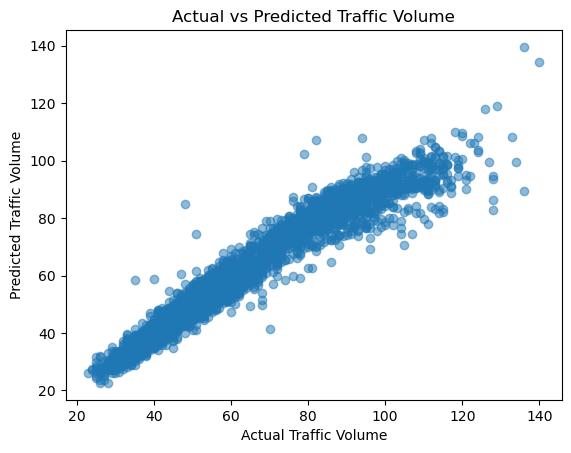

In [20]:
# Prediction vs Actual Plot

plt.figure()
plt.scatter(y_val, y_pred_gbr, alpha=0.5)
plt.xlabel("Actual Traffic Volume")
plt.ylabel("Predicted Traffic Volume")
plt.title("Actual vs Predicted Traffic Volume")
plt.show()

*Points closer to the diagonal indicate better predictions*

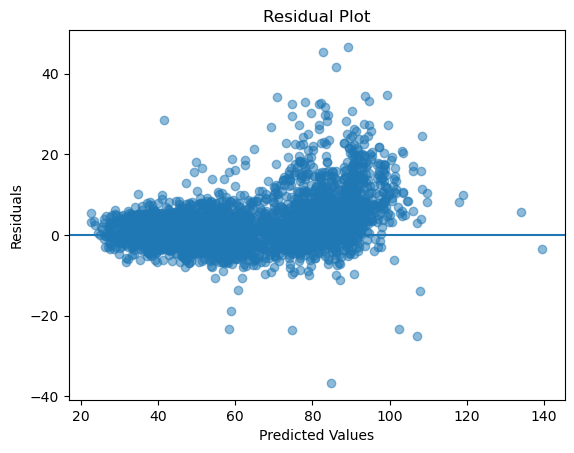

In [21]:
# Residual Plot

# Compute residuals (difference between actual and predicted values)
residuals = y_val - y_pred_gbr

plt.figure()
plt.scatter(y_pred_gbr, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

*Randomly scattered residuals around zero indicate a well-fitted model*

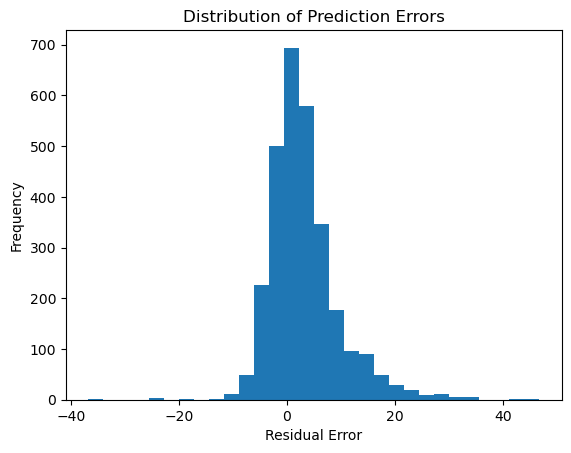

In [22]:
# Error Distribution

plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

*A distribution centered around zero suggests unbiased predictions*

#### Time-Based Cross-Validation

In [23]:
# Perform time-based cross-validation to evaluate model robustness

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store evaluation metrics for each fold
mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in tscv.split(X):
    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

# Train Gradient Boosting model on each fold    
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )
    
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    
    mae_scores.append(mean_absolute_error(y_va, preds))
    rmse_scores.append(mean_squared_error(y_va, preds, squared=False))
    r2_scores.append(r2_score(y_va, preds))

In [24]:
print("Cross-Validation Results")
print("MAE :", np.mean(mae_scores))
print("RMSE:", np.mean(rmse_scores))
print("R²  :", np.mean(r2_scores))

Cross-Validation Results
MAE : 4.639569854981024
RMSE: 6.502196558319033
R²  : 0.8400669793580194


*Consistent scores across folds indicate good generalization*

#### CV Stability Analysis

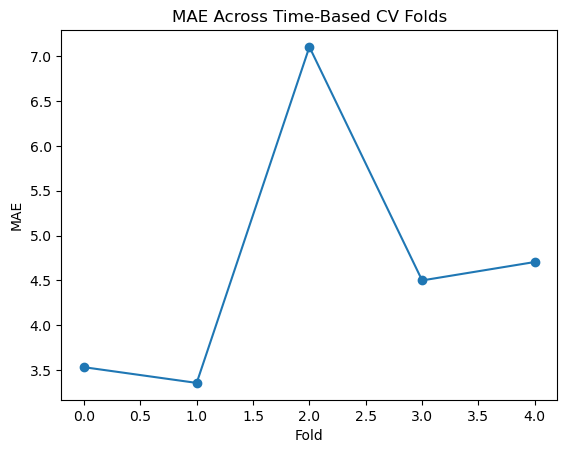

In [25]:
# Plot MAE across cross-validation folds to assess performance stability

plt.figure()
plt.plot(mae_scores, marker='o')
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE Across Time-Based CV Folds")
plt.show()

*Small variation between folds suggests a stable and robust model*

# Model Refinement

#### Diagnose Model Issues

In [26]:
# Error Analysis

# Difference between actual and predicted values
residuals = y_val - y_pred_gbr

print("Mean residual:", residuals.mean()) # Mean residual close to zero indicates low systematic bias
print("Std of residuals:", residuals.std()) # Standard deviation measures spread of errors (model consistency)

Mean residual: 3.1349622790248852
Std of residuals: 6.545576772652248


#### Hyperparameter Tuning and Best Model Identification

In [27]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the hyperparameter search space for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# Use time-based cross-validation to avoid data leakage
tscv = TimeSeriesSplit(n_splits=3)

# Grid search to find optimal hyperparameters based on MAE
grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


*This step refines the model by systematically exploring hyperparameters to reduce prediction error while maintaining temporal integrity.*